In [1]:
!pip install trimesh

     |████████████████████████████████| 634kB 12.2MB/s 


In [2]:
from google.colab import drive
from os.path import join

ROOT = '/content/drive'     # default for the drive
PROJ = 'My Drive/draping_workspace'       # path to your project on Drive

drive.mount(ROOT)

Mounted at /content/drive


In [3]:
import trimesh
import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt
import torch

In [ ]:
tool_mesh = trimesh.load('/content/drive/My Drive/draping_workspace/0018_rig000.obj',process=False)
fabric_mesh = trimesh.load('/content/drive/My Drive/draping_workspace/0018_000.obj',process=False)

In [ ]:
tool_mesh = trimesh.load('/content/drive/My Drive/draping_workspace/0040_rig000.obj',process=False)
fabric_mesh = trimesh.load('/content/drive/My Drive/draping_workspace/0040_000.obj',process=False)

In [ ]:
tool_mesh = trimesh.load('/content/double_hump_draping_default_out/out3/0011_rig000.obj',process=False)
fabric_mesh = trimesh.load('/content/double_hump_draping_default_out/out3/0011_000.obj',process=False)

In [120]:
tool_mesh = trimesh.load('/content/drive/My Drive/draping_workspace/0000_rig000.obj',process=False)
fabric_mesh = trimesh.load('/content/drive/My Drive/draping_workspace/double_hump_simplified_phase1_complete.obj',process=False)
boundary = [ 26,  63,  91,  62,  61, 116, 124,  93, 105,  27, 157,  78,  66,
          7, 153, 103, 129,  88, 122,  99,  89, 142, 149,  44,   6, 126,
         24,  60,  21,  11,  49, 150, 136, 139,   2,  53, 117,  36,   0]

seed_pt_idx = 83

#fabric_mesh.vertices += np.array([0.5,0.0,-0.1])

In [ ]:
tool_mesh = trimesh.load('/content/drive/My Drive/draping_workspace/0000_rig000.obj',process=False)
fabric_mesh = trimesh.load('/content/drive/My Drive/draping_workspace/0025_000.obj',process=False)
seed_pt_idx = 83

In [121]:
scene = trimesh.Scene([tool_mesh, fabric_mesh])
scene.show(viewer='notebook')

In [134]:
torch_fabric_v = torch.tensor(fabric_mesh.vertices)
torch_fabric_f = torch.tensor(fabric_mesh.faces)

torch_tool_v = torch.tensor(tool_mesh.vertices)
torch_tool_f = torch.tensor(tool_mesh.faces)
torch_tool_n = torch.tensor(tool_mesh.vertex_normals)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  


(array([135.,   5.,   5.,   1.,   2.,   0.,   0.,   1.,   0.,   9.]),
 array([3.85148339e-90, 1.00000000e-01, 2.00000000e-01, 3.00000000e-01,
        4.00000000e-01, 5.00000000e-01, 6.00000000e-01, 7.00000000e-01,
        8.00000000e-01, 9.00000000e-01, 1.00000000e+00]),
 <a list of 10 Patch objects>)

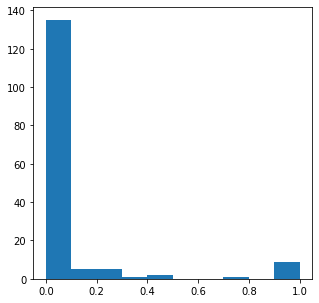

In [207]:
z_dists = torch.nn.functional.relu((torch_fabric_v - torch_tool_v)[:,2])

dists = []
for i in range(torch_fabric_v.shape[0]):
    dists.append(torch.dot(torch_fabric_v[i] - torch_tool_v[i],torch_tool_n[i]))

#n_dists = torch.einsum('ij,ij->i', torch_fabric_v - torch_tool_v, torch_tool_n)

n_dists = torch.stack(dists)
pos_n_dists = torch.nn.functional.relu(n_dists)

thresh = 5e-3

z_weights = torch.exp(-z_dists/thresh)

n_weights = torch.exp(-pos_n_dists/thresh)

plt.rcParams["figure.figsize"] = (5,5)
plt.hist(z_weights)

In [202]:
xy = torch_fabric_v[:,0:2]
xy_tool = torch_tool_v[:,0:2]
contact = xy[n_weights>0.99]
noncontact = xy[n_weights<0.99]

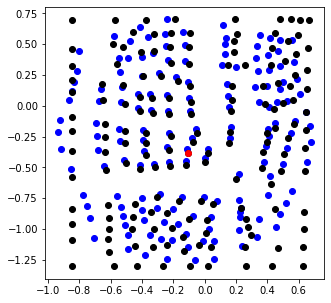

In [203]:
plt.scatter(xy[:,0].numpy(), xy[:,1].numpy(),c='blue')
plt.scatter(xy_tool[:,0].numpy(), xy_tool[:,1].numpy(),c='black')
plt.scatter(xy_tool[seed_pt_idx,0].numpy(), xy_tool[seed_pt_idx,1].numpy(),c='red')

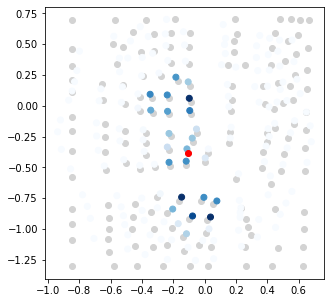

In [211]:
plt.scatter(xy_tool[:,0].numpy(), xy_tool[:,1].numpy(),c='lightgrey')
plt.scatter(xy[:,0].numpy(), xy[:,1].numpy(), c=n_weights.numpy(), cmap='Blues')
plt.scatter(xy_tool[seed_pt_idx,0].numpy(), xy_tool[seed_pt_idx,1].numpy(),c='red')

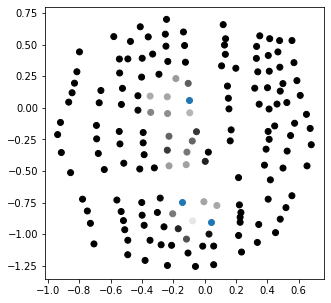

In [209]:
plt.scatter(xy[:,0].numpy(), xy[:,1].numpy(), c=n_weights.numpy(), cmap='gray')
plt.scatter(contact[:,0].numpy(), contact[:,1].numpy())

In [ ]:
A = xy
C = A.mean(dim=(-2,), keepdim=True)
U,S,V = torch.svd(A - C)
P2 = torch.matmul(A, V[:, :2])
P1 = torch.matmul(A, V[:, :1])

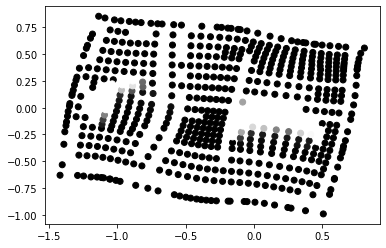

In [ ]:
plt.scatter(P2[:,0], P2[:,1], c=weights.numpy(), cmap='gray')

In [ ]:
plt.scatter(p[:,0],weights)

NameError: name 'p' is not defined

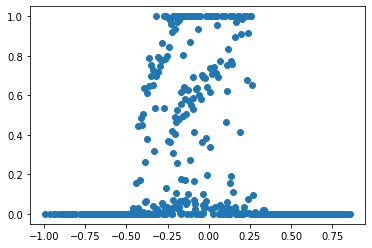

In [ ]:
plt.scatter(p[:,1],weights)

(array([15.,  5.,  0.,  0.,  0.,  0.,  9.,  6.,  6.,  8.]),
 array([-1.21907424, -1.04815379, -0.87723334, -0.70631289, -0.53539244,
        -0.364472  , -0.19355155, -0.0226311 ,  0.14828935,  0.3192098 ,
         0.49013024]),
 <a list of 10 Patch objects>)

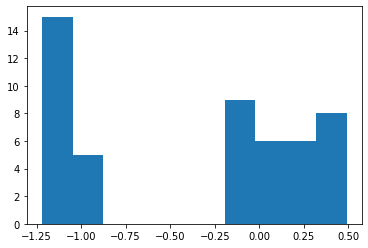

In [ ]:
plt.hist(p[weights>0.99,0])

In [ ]:
def get_moments(d):
    mean = torch.mean(d,0,keepdim=True)
    diffs = d - mean
    var = torch.mean(torch.pow(diffs, 2.0),0,keepdim=True)
    std = torch.pow(var, 0.5)
    zscores = diffs / std
    skews = torch.mean(torch.pow(zscores, 3.0),0,keepdim=True)
    kurtoses = torch.mean(torch.pow(zscores, 4.0),0,keepdim=True)
    return torch.cat((mean,std,skews,kurtoses)).transpose(1,0)

def pca(xy):
    A = xy
    #center
    C = A.mean(dim=(-2,), keepdim=True)
    U,S,V = torch.svd(A - C)
    #project onto principal components
    P2 = torch.matmul(A, V[:, :2])
    P1 = torch.matmul(A, V[:, :1])
    return P2

def test(moments):
    #BC multimodality test
    skewness = moments[:,2]
    kurtoses = moments[:,3]
    return (skewness**2 + 1)/kurtoses

z_dists = torch.nn.functional.relu((torch_fabric_v - torch_tool_v)[:,2])
thresh = 1e-2
weights = torch.exp(-z_dists/thresh)

xy = torch_fabric_v[:,0:2]

loss = 0

if(torch.any(weights > 0.99)):
    p = pca(xy)
    m = get_moments(p[weights>0.99])
    max_bc = torch.logsumexp(test(m)*1e1,dim=0)/1e1 #higher is worse
    loss += torch.exp(10*((max_bc - 0.555)/0.445))
    
print(loss)

tensor(214.0596, dtype=torch.float64)


In [218]:
import networkx as nx
import torch
import itertools

#precalculate all pairs shortest paths
G = nx.Graph()
G.add_edges_from(fabric_mesh.edges_unique)
P = dict(nx.all_pairs_shortest_path(G))

def contact_front_loss_graph(seed_pt_idx, thresh = 5e-3):
    dists = []
    for i in range(torch_fabric_v.shape[0]):
        dists.append(torch_fabric_v[i] - torch_tool_v[i])

    z_dists = torch.stack(dists)[:,2]

    pos_z_dists = torch.nn.functional.relu(z_dists)
    weights = torch.exp(-pos_z_dists/thresh)

    vertex_connectivity = torch.tensor(0.0)

    for j in range(torch_fabric_v.shape[0]):
        vertex_connectivity += weights[P[seed_pt_idx][j]].prod()

    loss = -vertex_connectivity

    return loss

def total_contact_loss_dist(exclude_indices = None, thresh = 5e-3):

    if exclude_indices is None: 
        exclude_indices = []

    one_rings = [list(G[i].keys()) for i in exclude_indices]
    exclude_indices.append(list(itertools.chain(*one_rings)))

    dists = []
    xy = []
    for i in range(torch_fabric_v.shape[0]):
        if not i in exclude_indices:
          dists.append(torch_fabric_v[i] - torch_tool_v[i])
          xy.append(torch_fabric_v[i][0:2])

    z_dists = torch.stack(dists)[:,2]

    pos_z_dists = torch.nn.functional.relu(z_dists)
    weights = torch.exp(-pos_z_dists/thresh)
    contact_loss = torch.mean(weights)

    return contact_loss, torch.stack(xy), weights

def total_contact_loss_dist_normal(exclude_indices = None, thresh = 5e-3):

    if exclude_indices is None: 
        exclude_indices = []

    one_rings = [list(G[i].keys()) for i in exclude_indices]
    exclude_indices.append(list(itertools.chain(*one_rings)))

    dists = []
    xy = []
    for i in range(torch_fabric_v.shape[0]):
        if not i in exclude_indices:
          dists.append(torch.dot(torch_fabric_v[i] - torch_tool_v[i],torch_tool_n[i]))
          xy.append(torch_fabric_v[i][0:2])

    n_dists = torch.stack(dists)

    pos_z_dists = torch.nn.functional.relu(n_dists)
    weights = torch.exp(-pos_z_dists/thresh)
    contact_loss = torch.mean(weights)

    return contact_loss, torch.stack(xy), weights

#we can calulate this offline
def calculate_rings(seed_pt_idx, boundary):
    rings = []
    rings.append([seed_pt_idx])
    while True:
        next_ring = [list(G[i].keys()) for i in rings[-1]]
        next_ring_no_center = set(itertools.chain(*next_ring)) - set(itertools.chain(*rings))
        rings.append(list(next_ring_no_center))
        if set(boundary) <= set(itertools.chain(*rings)):
            return rings[1:]

rings = calculate_rings(seed_pt_idx, boundary)

def ring_contact_loss(rings,thresh = 5e-3):

    dists = []
    for i in range(torch_fabric_v.shape[0]):
        dists.append(torch_fabric_v[i] - torch_tool_v[i])

    z_dists = torch.stack(dists)[:,2]

    pos_z_dists = torch.nn.functional.relu(z_dists)
    weights = torch.exp(-pos_z_dists/thresh)

    #ring_weights = np.linspace(100,0,len(rings))

    contact = torch.tensor(0.0)

    for i in range(len(rings)):
        contact += weights[rings[i]].mean()#*ring_weights[i]

    return contact

def ring_contact_loss_normal(rings,thresh = 5e-3):

    n_dists = torch.einsum('ij,ij->i', torch_fabric_v - torch_tool_v, torch_tool_n)

    pos_n_dists = torch.nn.functional.relu(n_dists)
    weights = torch.exp(-pos_n_dists/thresh)

    #ring_weights = np.linspace(100,0,len(rings))

    contact = torch.tensor(0.0)

    for i in range(len(rings)):
        contact += weights[rings[i]].mean()#*ring_weights[i]

    return contact

def ring_contact_loss_normal_(rings,thresh = 5e-3):

    dists = []
    for i in range(torch_fabric_v.shape[0]):
        dists.append(torch.dot(torch_fabric_v[i] - torch_tool_v[i],torch_tool_n[i]))

    #n_dists = torch.einsum('ij,ij->i', torch_fabric_v - torch_tool_v, torch_tool_n)

    n_dists = torch.stack(dists)
    pos_n_dists = torch.nn.functional.relu(n_dists)
    # weights = torch.exp(-pos_n_dists/thresh)

    ring_weights = np.linspace(10,0,len(rings))

    contact = torch.tensor(0.0)

    # for i in range(len(rings)):
    #     contact += weights[rings[i]].mean()#*ring_weights[i]

    for i in range(len(rings)):
        contact += pos_n_dists[rings[i]].mean()*ring_weights[i]

    return contact

def on_target_loss():
    dists = []
    for i in range(torch_fabric_v.shape[0]):
        dists.append(torch.norm((torch_fabric_v[i] - torch_tool_v[i])[0:2]))
    twodee_dists = torch.stack(dists)

    return twodee_dists

def on_target_loss_normal():
    dists = []
    for i in range(torch_fabric_v.shape[0]):
        dists.append(torch.norm((torch_fabric_v[i] -torch_tool_v[i]) - (torch.dot(torch_fabric_v[i] - torch_tool_v[i],torch_tool_n[i])* torch_tool_n[i])))
    plane_dists = torch.stack(dists)

    return plane_dists

In [219]:
contact_loss, xy, weights = total_contact_loss_dist([seed_pt_idx],5e-3)

normal_contact_loss, xy, weights = total_contact_loss_dist_normal([seed_pt_idx],5e-3)

In [198]:
plane_dists = on_target_loss_normal()
plane_dists.mean()

tensor(0.1733, dtype=torch.float64)

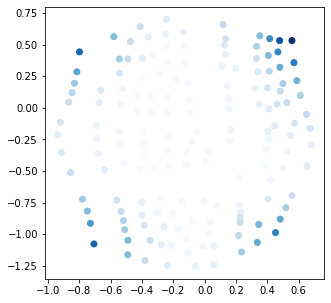

In [196]:
plt.scatter(xy[:,0].numpy(), xy[:,1].numpy(), c=plane_dists.numpy(), cmap='Blues')


In [199]:
ring_contact_loss_normal_(rings)

tensor(0.9270)

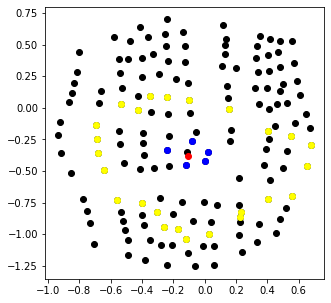

In [64]:
plt.scatter(xy[:,0].numpy(), xy[:,1].numpy(),c='black')
plt.scatter(xy[rings[1],0].numpy(), xy[rings[1],1].numpy(),c='blue')
plt.scatter(xy[rings[4],0].numpy(), xy[rings[4],1].numpy(),c='yellow')


plt.scatter(xy_tool[seed_pt_idx,0].numpy(), xy_tool[seed_pt_idx,1].numpy(),c='red')

In [ ]:
weights[P[seed_pt_idx][83]].prod()

tensor(1., dtype=torch.float64)

In [13]:
seed_pt_idx = 83
step_contact_loss, xy_contact, xy_contact_weights = total_contact_loss_dist([seed_pt_idx],5e-3)
step_contact_front_loss = contact_front_loss_graph(seed_pt_idx,5e-3)

print(f"step_contact_loss: {step_contact_loss}, step_contact_front_loss: {step_contact_front_loss}")

step_contact_loss: 0.07688240606596722, step_contact_front_loss: -10.918497085571289


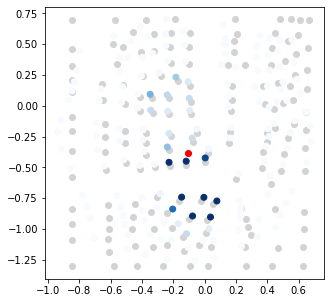

In [14]:
plt.scatter(xy_tool[:,0].numpy(), xy_tool[:,1].numpy(),c='lightgrey')
plt.scatter(xy_contact[:,0].numpy(), xy_contact[:,1].numpy(), c=xy_contact_weights.numpy(), cmap='Blues')
plt.scatter(xy_tool[seed_pt_idx,0].numpy(), xy_tool[seed_pt_idx,1].numpy(),c='red')

In [ ]:
plt.rcParams["figure.figsize"] = (20,20)
plt.scatter(xy[:,0].numpy(), xy[:,1].numpy())
for i in range(fabric_mesh.vertices.shape[0]):
    plt.text(fabric_mesh.vertices[i,0], fabric_mesh.vertices[i,1], f'{vertex_connectivity[i]:.0f}',fontsize=8)

NameError: name 'xy' is not defined

Laplacian Clustering attempt (but not useful/non differentiable)

In [ ]:
import networkx as nx
A = nx.adjacency_matrix(fabric_mesh.vertex_adjacency_graph)
D = np.diag(A.sum(axis=1))
A = torch.tensor(A.todense())
mod_weights = torch.tensor(weights)
mod_weights[mod_weights <= 0.99] = 0
mod_weights[mod_weights > 0.99] = 1
A = (A*mod_weights).numpy()



In [ ]:
A

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
# create the graph laplacian
L = D-A

# find the eigenvalues and eigenvectors
vals, vecs = np.linalg.eig(L)

# sort
vecs = vecs[:,np.argsort(vals)]
vals = vals[np.argsort(vals)]